## Binary Image Classification: Pizza vs. Not Pizza
Our goal is to build a binary image classifier. Through applying different machine learning classification techniques, we are hoping to differentiate between images of pizza and images of other food that is not pizza
#### Our dataset
We found our data on Kaggle. https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza The dataset contains 1966 images with an even split between images that are pizza and images that are not. Each image is 512 pixels on the longest side. 


#### Libraries that we are using

In [1]:
# for image manipulation
import cv2
from scipy import ndimage

# for displaying graphs and image
import matplotlib.pyplot as plt

# for machine learning
import sklearn

# general purpose 
import os
import numpy as np

#### Transforming data
These steps will take the training data, transform it, and output the cleaned, ready to use data into a new dataset folder. In the dataset, the images are already resized to have a max length of 512 pixels, but we want images of exactly the same size. The transformation steps include rotating all images to be landscape, changing the aspect ratio of all images to 3:4, and decreasing resolution by half.

In [2]:
paths = ['/not_pizza/', '/pizza/']

for path in paths:
    os.makedirs('clean_data' + path, exist_ok=True)
    
    for filename in os.listdir("pizza_not_pizza" + path):
        # load image
        img = cv2.imread("pizza_not_pizza" + path + filename)
    
        # if the image is horizontal, rotate so it's vertical
        if img.shape[0] > img.shape[1]:
            rot_img = np.transpose(img, (1, 0, 2))  
        else:
            rot_img = img
        
        # Semi random decision, change if necessary
        # reshape all images to be 3:4 and about half of original dimensions, that is 192 by 256 
        # (since all original images have one dim that is 512)
        new_img = cv2.resize(rot_img,(256, 192)) # width by height so axes are swapped when passed in

        # write image to new directory, preserving dir structure & filenames
        new_path = 'clean_data' + path + filename
        cv2.imwrite(new_path, new_img)
    

#### Loading the data
Once the data is transformed and stored to a new folder, we load it into the X array and create targets y.

In [3]:
# load in data
X = []
paths = ['/not_pizza/', '/pizza/']
for path in paths:
    for filename in os.listdir("clean_data" + path):
        # load image
        img_array = cv2.imread("clean_data" + path + filename)
        X.append(img_array.flatten()) # flatten to 1D array
    print(f"files from {path} loaded")
    
X = np.array(X)
print(X.shape)

files from /not_pizza/ loaded
files from /pizza/ loaded
(1966, 147456)


In [4]:
# create array of labels, with pizza as class 0 and ice cream as class 1
num_not_pizza = len([f for f in os.listdir("clean_data/not_pizza")])
num_pizza = len([f for f in os.listdir("clean_data/pizza")])

y = np.concatenate((np.zeros(num_not_pizza), np.ones(num_pizza)))

# make sure all data is loaded
assert len(y) == len(X)
assert len(X) == 1966

#### A Sample of the dataset
Here is a selection of images from both classes in the dataset

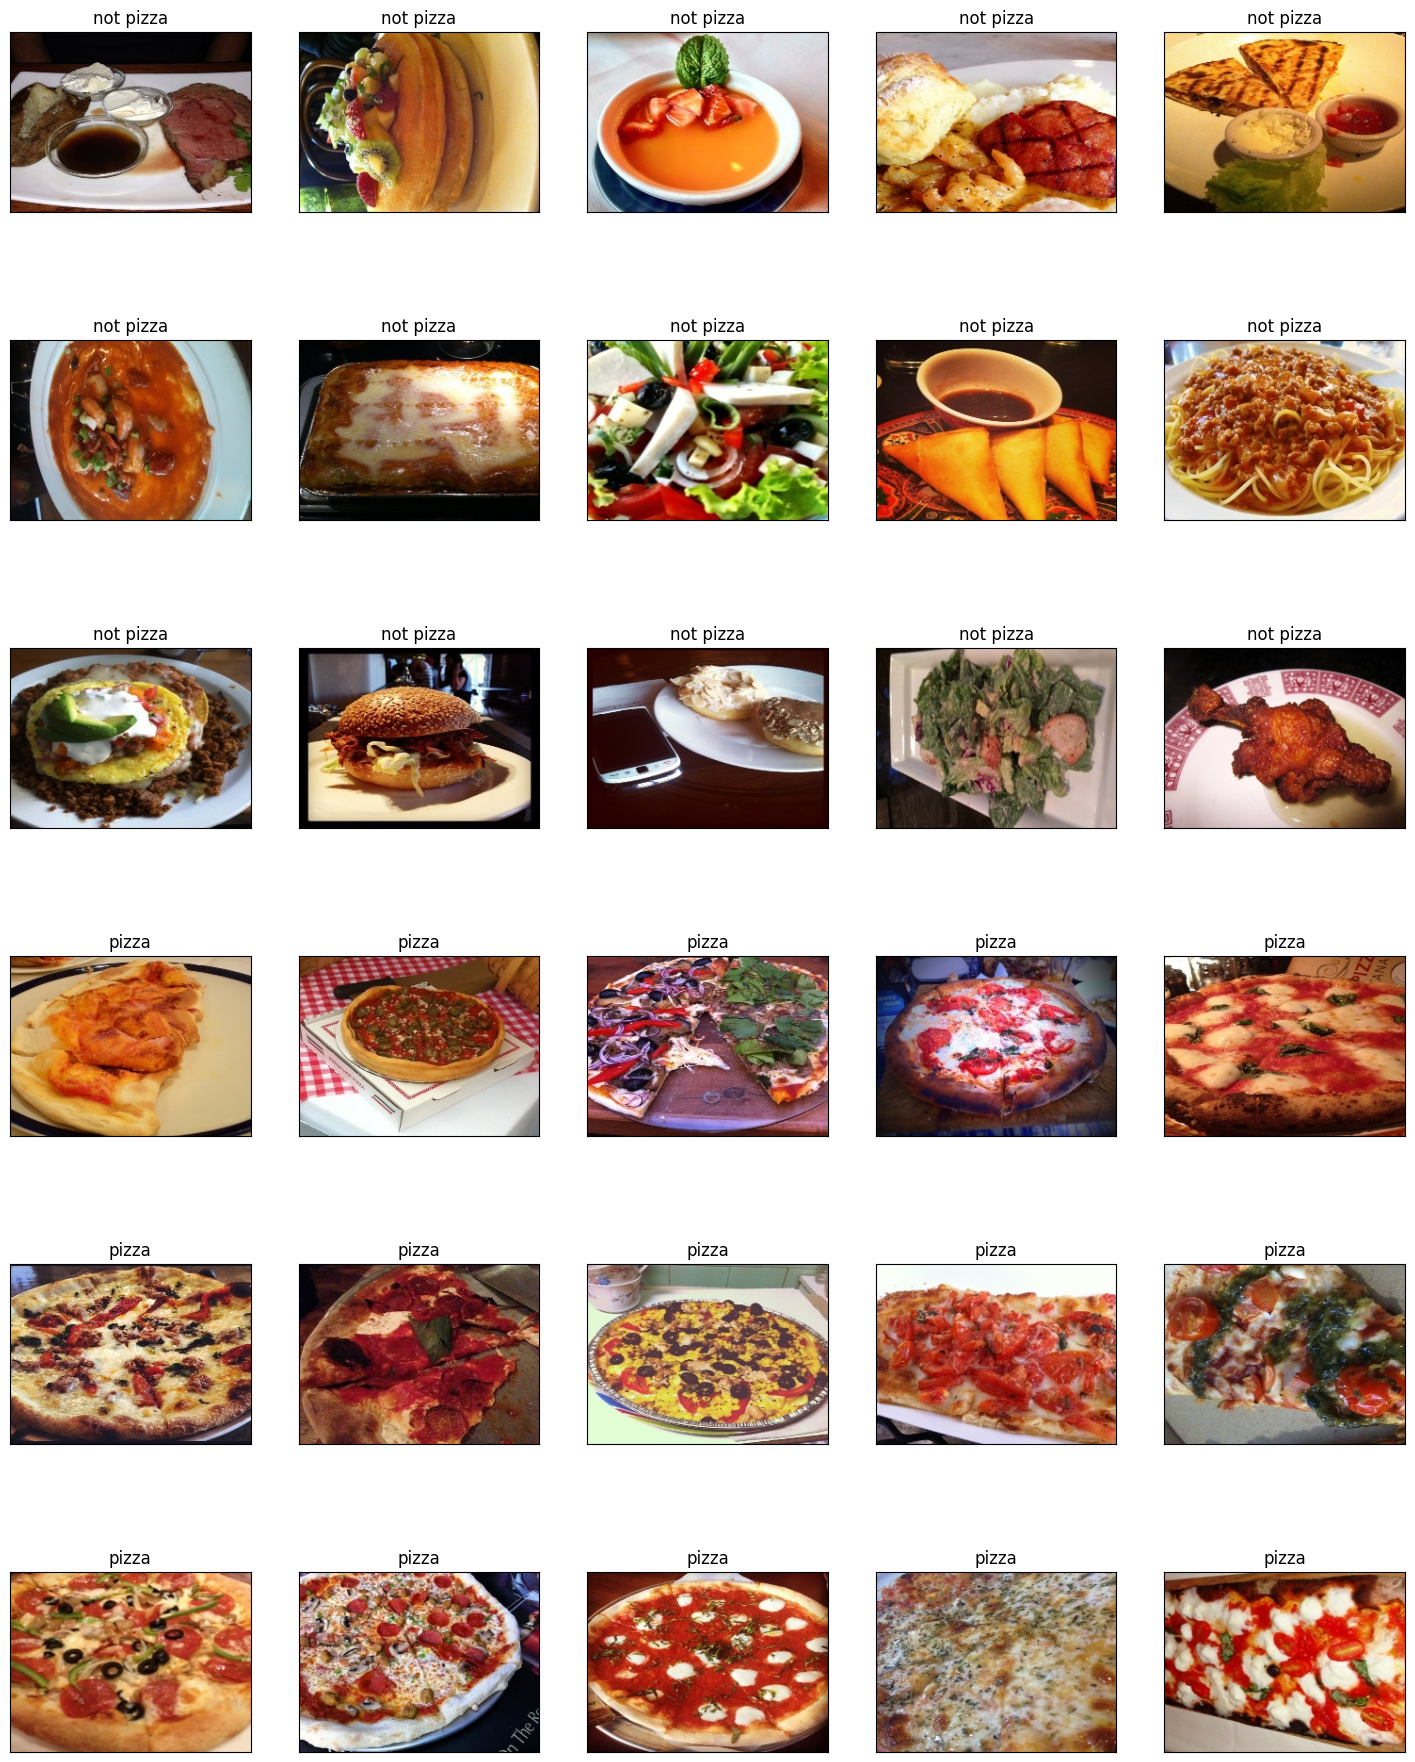

In [5]:
import matplotlib.pyplot as plt

not_pizza_imgs = X[0:15]
pizza_imgs = X[983:998]
together = np.concatenate((not_pizza_imgs, pizza_imgs))
targets_together = np.concatenate((y[0:15], y[983:998]))

fig, axes = plt.subplots(6, 5, figsize=(18, 24), subplot_kw={'xticks': (), 'yticks': ()})

plt.subplots_adjust(hspace=0)
for target, image, ax in zip(targets_together, together, axes.ravel()):
    img = np.reshape(image, (192, 256, 3))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGBA2BGR))
    ax.set_title("pizza" if target == 1 else "not pizza")

#### Implementing K Nearest Neighbors
For starters, we tried the K Nearest Neighbors approach because it was one of the simplest and allowed us to make sure we had loaded the dataset correctly. In order to get an accurate representation of how well it does, we ran it 10 times on different splits of training and test data.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

print("Run # \t Training Score \t Test Score")
test_total = 0.0
training_total = 0.0

for x in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    knn_model = KNeighborsClassifier(n_neighbors=7)
    knn_model.fit(X_train, y_train)
    training_score = knn_model.score(X_train, y_train)
    test_score = knn_model.score(X_test, y_test)
    training_total += training_score
    test_total += test_score
    
    print(f"{x} \t {training_score} \t {test_score}")
    
print("\nAverage Scores")
print(f"Training: {training_total / 10}")
print(f"Test: {test_total / 10}")

Run # 	 Training Score 	 Test Score
0 	 0.710559796437659 	 0.6243654822335025
1 	 0.7264631043256997 	 0.6294416243654822
2 	 0.7022900763358778 	 0.6395939086294417
3 	 0.6927480916030534 	 0.6269035532994924
4 	 0.7016539440203562 	 0.6649746192893401
5 	 0.6921119592875318 	 0.5939086294416244
6 	 0.7137404580152672 	 0.6446700507614214
7 	 0.7232824427480916 	 0.565989847715736
8 	 0.7283715012722646 	 0.6116751269035533
9 	 0.7347328244274809 	 0.6624365482233503

Average Scores
Training: 0.7125954198473282
Test: 0.6263959390862943


This model does okay, scoring an average of .72 on the training set and .63 on the test set. It potentially doesn't do super well because the dimensions of the datapoints are quite large (147456) so the curse of dimensionality makes neighbors farther apart. There's probably a way we can do this better.

#### Trying Principal Component Analysis
Hopefully using PCA we can find the most informative components and reduce the dimensionality of the data while still keeping enough information to create a good classifier

In [7]:
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pca = PCA(n_components=200, whiten=True).fit(X_train) # keeps 200 most informative components

# data mapped onto pca space
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [8]:
# Trying KNN on this transformed data
knn_model_pca = KNeighborsClassifier(n_neighbors=5)
knn_model_pca.fit(X_train_pca, y_train)
knn_model_pca.score(X_test_pca, y_test)

0.5228426395939086

The transformed data does a bit worse, getting a score slightly above 50%. With PCA, we reduce the dimensionality and lose some of the accuracy. 

#### Implementing Support Vector Machines

Maybe the problem is that KNN is too simple and a different model might perform better. To explore this possibility, we tried support vector machines

In [9]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.91
Accuracy on test set: 0.74


#### Trying Support Vector Machines with Principal Component Analysis

Performing SVM with PCA is much faster than performing the typical SVM above. 

In [10]:
from sklearn.svm import SVC

# all pixels will have same scale
# easier to do SVM with PCA because taking too long without PCA
svc = SVC()
svc.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test_pca, y_test)))

Accuracy on training set: 0.94
Accuracy on test set: 0.67


Next, to see if our results were consistent, we performed SVM with PCA over 3 trials. 

In [11]:
#### SVM with PCA over many trials

In [12]:
i = 0
max_iter = 3
total_train = 0
total_test = 0

while (i < max_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    pca = PCA(n_components=200).fit(X_train) # keeps 200 most informative components
    # data mapped onto pca space
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    svc = SVC()
    svc.fit(X_train_pca, y_train)

    total_train = total_train + svc.score(X_train_pca, y_train)
    total_test = total_test + svc.score(X_test_pca, y_test)
    i=i+1
    
print("Accuracy on training set: {:.2f}".format(total_train/max_iter))
print("Accuracy on test set: {:.2f}".format(total_test/max_iter))

Accuracy on training set: 0.89
Accuracy on test set: 0.74


#### Implementing Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear").fit(X_train, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 1.000
Test set score: 0.591


#### Trying Principal Component Analysis

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver="liblinear").fit(X_train_pca, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train_pca, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test_pca, y_test)))

Training set score: 0.744
Test set score: 0.655


#### Implementing Neural Nets

In [15]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=200, alpha=.001, random_state=42, hidden_layer_sizes=([100, ]), solver = "lbfgs")
mlp.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.63


#### Trying Principal Component Analysis

The following code tries neural nets with the default setting. 

In [16]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.2f}".format(mlp.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.2f}".format(mlp.score(X_test_pca, y_test)))

Accuracy on training set: 1.00
Accuracy on test set: 0.59


In the following code, we can adjust some of the settings. 

In [17]:
mlp = MLPClassifier(max_iter=10000, alpha=1, random_state=0, hidden_layer_sizes=([10, ]))
mlp.fit(X_train_pca, y_train)

print("Accuracy on training set: {:.3f}".format(
    mlp.score(X_train_pca, y_train)))
print("Accuracy on test set: {:.3f}".format(mlp.score(X_test_pca, y_test)))

Accuracy on training set: 0.950
Accuracy on test set: 0.619


#### Using a CNN

To do this, we followed the steps for preparing data and building a model that we went through as a class in the lab on Deep learning. This code is copied from that lab and then modified as necessary for our situation

In [18]:
import tensorflow as tf
from tensorflow import keras

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# load in data - without flattening
X_cnn = []
paths = ['/not_pizza/', '/pizza/']
for path in paths:
    for filename in os.listdir("clean_data" + path):
        # load image
        img_array = cv2.imread("clean_data" + path + filename)
        X_cnn.append(img_array)
    print(f"files from {path} loaded")
    
X_cnn = np.array(X_cnn)

# Normalize pixel values to be between 0 and 1
X_cnn = X_cnn / 255.0
print(X_cnn.shape)

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[192, 256, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [ ]:
from sklearn.model_selection import train_test_split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y, test_size=0.2)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train_cnn, y_train_cnn, epochs=10)#, validation_data=(X_valid, y_valid))

In [ ]:
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

This simple CNN does really well! It took around 20 minutes to train, but with 10 epochs, it achieved a score of .99 on the training set and .92 on the test set. 

#### Conclusions
